In [1018]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/work-vacation-price-prediction-dataset/sample submission.csv
/kaggle/input/work-vacation-price-prediction-dataset/Train.csv
/kaggle/input/work-vacation-price-prediction-dataset/Test.csv


# <font color = blue> _Workation Price Prediction_</font>
****
**_Overview_**
***
The new covid-era has provided a new way of living the work-life balance. We have seen a lot of different websites providing packages to work from different locations. From Kashmir to Kanyakumari, from Gujarat to Assam we have collected packages in and around India. It becomes really difficult to find the best place with all the amenities such as high-speed internet, a comfortable stay as well as within the budget. To solve the real-world problem of finding the best deals for a calm and enjoying workation trip. Workation is the best way to work at a remote location with a recreational and rejuvenating vacation for the team.

In this competition, one has to use the knowledge of machine learning, deep learning, and model building to predict the price per person for your next workstation trip. The data has more than 18000+ rows of different packages with the details like start location, hotel type, cost per person, destination, Itinerary, and many more.

## _Load the Libraries_

In [1019]:
#arrays and dataframes operations 
import os
import math
from pprint import pprint
import statistics
import numpy as np
import pandas as pd
from datetime import date
#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
#consistent plot sizes
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
#handle unwanted warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
#display all the columns
pd.options.display.max_columns = False
#import label encoder
from sklearn.preprocessing import LabelEncoder
#import transformer
from sklearn.preprocessing import PowerTransformer
#import the modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
#linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
#ensemble techniqques
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#xgboost
from xgboost import XGBRegressor
#pipeline
from sklearn.pipeline import Pipeline
#model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
#dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import LocallyLinearEmbedding

#helper function
#create a feature with the number of occurences

def num_sightseeing(dataset,col='Sightseeing Places Covered'):
    
    '''This function returns the number of attributes separated by |. 
    The function was written later in the code but found its usefulness for multiple features.
    Hence it is added here and the name of the function resembles it is only for sight seeing 
    feature which is not the case in reality. '''
    
    num_sightseeing = []
    for i in range(len(dataset)):
        if dataset[col][i] == 'Not Available':
            num_sightseeing.append(-1)
        else:
            num_sightseeing.append(dataset[col][i].count('|'))    
    return num_sightseeing 

## _Load the data and Basic Sanity Checks_

In [1020]:
#load as pandas dataframe
train = pd.read_csv('/kaggle/input/work-vacation-price-prediction-dataset/Train.csv',delimiter=',',engine='python')
test =  pd.read_csv('/kaggle/input/work-vacation-price-prediction-dataset/Test.csv',delimiter=',',engine='python')

In [1021]:
#check the few top rows
train.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0


In [1022]:
test.head(3)

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules
0,12c47aefbcca65d6156ba0bc7946704b,Goa 5N stay with flights & Transfers-North Goa,Luxury,Goa,5N Goa,Goa,13-07-2021,Novotel Goa Resort & Spa:4.1,New Delhi,IndiGo,0,4,Not Available,Cancellation any time after making the 1st pay...
1,156febf7d27315ae9f210ed13bca3ac2,Into the Wild - Weekend at Bandipur National Park,Luxury,Bandipur,2N Bandipur,Bandipur,20-03-2021,The Windflower Jungle Resorts & Spa Bandipur:4.4,New Delhi,Not Available,0,4,Bandipur National Park,This cancellation policy is applicable for boo...
2,a7f43314e3ee6464a4e35b874bddf2ea,Unforgettable Munnar Getaway - Private Picnic ...,Standard,Munnar,3N Munnar,Munnar,09-02-2022,Not Available,New Delhi,Not Available,2,3,Old Munnar Town | Eravikulam national park | ...,This cancellation policy is applicable for boo...


In [1023]:
#check the info .. 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Uniq Id                     21000 non-null  object 
 1   Package Name                21000 non-null  object 
 2   Package Type                21000 non-null  object 
 3   Destination                 21000 non-null  object 
 4   Itinerary                   21000 non-null  object 
 5   Places Covered              21000 non-null  object 
 6   Travel Date                 21000 non-null  object 
 7   Hotel Details               21000 non-null  object 
 8   Start City                  21000 non-null  object 
 9   Airline                     21000 non-null  object 
 10  Flight Stops                21000 non-null  int64  
 11  Meals                       21000 non-null  int64  
 12  Sightseeing Places Covered  21000 non-null  object 
 13  Cancellation Rules          210

<b> _There are 21000 entries in the train dataset with 13 features and 1 target variable which is the price of the travel package. Flight stops, Meals are integers, price is in float whereas all teh rest of the features are of object/string type including the Travel Date. There are no null/NaN values in the dataset. However, there are feature rows where it mentions 'Not Available'. These are as good as NaNs_ </b>

**_There is no feature which states the end of the travel. The duration of the vacation can be derived from the Itinerary which mentions the number of nights_**

In [1024]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Uniq Id                     9000 non-null   object
 1   Package Name                9000 non-null   object
 2   Package Type                9000 non-null   object
 3   Destination                 9000 non-null   object
 4   Itinerary                   9000 non-null   object
 5   Places Covered              9000 non-null   object
 6   Travel Date                 9000 non-null   object
 7   Hotel Details               9000 non-null   object
 8   Start City                  9000 non-null   object
 9   Airline                     9000 non-null   object
 10  Flight Stops                9000 non-null   int64 
 11  Meals                       9000 non-null   int64 
 12  Sightseeing Places Covered  9000 non-null   object
 13  Cancellation Rules          9000 non-null   obje

In [1025]:
#check for number of rows where we have Not Available string
if train['Airline'].str.contains('Not Available').any():
    print ("Not Available is present")

Not Available is present


In [1026]:
#check the frequency of 'Not Available' in the train dataset
cat_features = train.select_dtypes(include='object').columns.tolist()
for col in cat_features:
    NA_count= train[col].str.contains('Not Available').sum()
    if NA_count>0:
        print ("In {} there are {} 'Not Available'".format(col,NA_count))

In Hotel Details there are 2929 'Not Available'
In Airline there are 4910 'Not Available'
In Sightseeing Places Covered there are 1623 'Not Available'
In Cancellation Rules there are 795 'Not Available'


In [1027]:
#check the frequency of 'Not Available' in the test dataset 
for col in cat_features:
    NA_count= test[col].str.contains('Not Available').sum()
    if NA_count>0:
        print ("In {} there are {} 'Not Available'".format(col,NA_count))

In Hotel Details there are 1238 'Not Available'
In Airline there are 2100 'Not Available'
In Sightseeing Places Covered there are 635 'Not Available'
In Cancellation Rules there are 347 'Not Available'


In [1028]:
#check for duplicates in the train data
train.duplicated().sum()

0

In [1029]:
#check the number of unique id's
len(train['Uniq Id'].unique())

21000

**_There are features which have a lot of occurrences which mentions 'Not Available'.  Secondly, there are no duplicate rows in the dataset. Third there are as many number of unique id's as is the number of observations_**

In [1030]:
#basic stats of the numerical features
train.describe()

,Flight Stops,Meals,Per Person Price
count,21000.000000,21000.000000,21000.000000
mean,0.870286,3.665429,20059.330381
std,0.834989,0.893631,11643.641766
min,0.000000,2.000000,791.000000
25%,0.000000,3.000000,12461.000000
50%,1.000000,3.000000,17765.500000
75%,2.000000,5.000000,25081.375000
max,2.000000,5.000000,171062.500000


<font color = blue>_The minimum number of meals is 2 and max is 5 with 3 as the median value. Flight stops on the other hand is 0 as min and 2 as max with median of 1_</font>

In [1031]:
#check the skew of the target variable 
train['Per Person Price'].skew()

2.5601007661713506

_The per person price median is 17765 and mean is 20059. The max value is 171062 rupees and the minimum is 791 rupees. The data at first glance appears to be right skewed_

## _Exploratory Data Analysis_

### _Explore the numerical features_

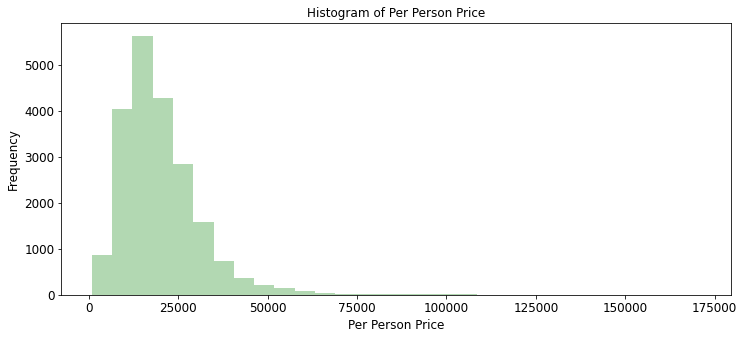

In [1032]:
#explore the price per person 
plt.hist(train['Per Person Price'],bins=30,histtype='stepfilled',color='green',alpha=0.3)
plt.title('Histogram of Per Person Price')
plt.xlabel('Per Person Price')
plt.ylabel('Frequency')
plt.show()

In [1033]:
#check for the normality of the target variable using Shapiro Wilk test
from scipy.stats import shapiro
warnings.filterwarnings(action='ignore')
data = train['Per Person Price']
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.837, p=0.000
Probably not Gaussian


**_The target variable is not Gaussian. Before building the prediction model, the target variable can be normalized so that the loss function can be optimized_**

In [1034]:
#create a list of numerical features
num_features = train.select_dtypes(exclude='object').columns.tolist()
num_features

['Flight Stops', 'Meals', 'Per Person Price']

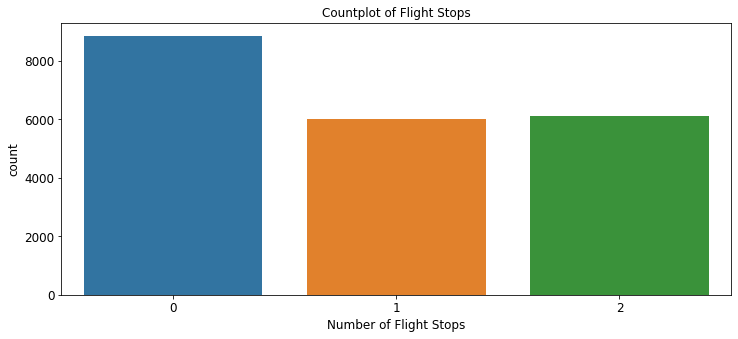

In [1035]:
#explore the Flight stops
sns.countplot(train['Flight Stops'])
plt.title('Countplot of Flight Stops')
plt.xlabel('Number of Flight Stops')
plt.show()

_There are more direct flight detsinations that the travellers have picked_

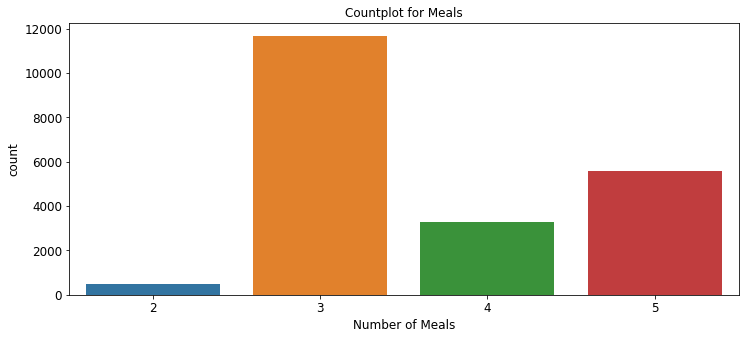

In [1036]:
#explore the price per person 
sns.countplot(train['Meals'])
plt.title('Countplot for Meals')
plt.xlabel('Number of Meals')
plt.show()

_There are more travellers having 3 meals per day as part of the package_

In [1037]:
#check the correlation between the numerical features
train.corr()['Per Person Price']

Flight Stops       -0.281276
Meals               0.266456
Per Person Price    1.000000
Name: Per Person Price, dtype: float64

**_There is negative correlation between the price per person and the number of flight stops. On the other hand there is positive correlation between the price per person and the number of meals selected as part of the package. This is expected as the non direct flights are usually cheaper than the direct ones_**

In [1038]:
#check the correlation b/n meals and flight stops
train[['Meals','Flight Stops']].corr()

,Meals,Flight Stops
Meals,1.000000,-0.835629
Flight Stops,-0.835629,1.000000


_This is expected as the number of meals per day will reduce with more flight stops. Only those meals are counted which are offered in the hotel stay or offered during the sight seeing. This also summarises the fact there is high multicollinearity in the dataset due to these two features._

In [1039]:
#check the travel package for which the price per person is very high
train[train['Per Person Price'] == train['Per Person Price'].min()]

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
17000,951d919359e22db4adbdc5fa0ac61f4b,Young and Free - Wayanad,Standard,Wayanad,2N Wayanad,Wayanad,08-08-2021,Holiday Hill Hotel and Suites:4.5,New Delhi,Not Available,2,3,Not Available,This cancellation policy is applicable for boo...,791.0


**_The start city is New Delhi and the destionation is Wayanad in way south of India. The Airline information is not available. Perhaps the airline booking option was not selected by the customer. The package name is young and free. While it cannot be ruled out the possibility of driving/train to this location, the fair assumption is that the flight booking would be done at a later date by the person_**

In [1040]:
#check the travel package for which the price per person is very high
train[train['Per Person Price'] == train['Per Person Price'].max()]

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
19476,128d80c1270b878a56fe33c8f0904751,"Ultimate Bali, Singapore & Kuala Lumpur (10N)",Deluxe,Bali|Singapore|Kuala Lumpur,5N Bali . 3N Singapore . 2N Kuala Lumpur,Bali|Singapore|Kuala Lumpur,19-05-2021,"White Rose Kuta Resort, Villas & Spa:4.0|MERCU...",New Delhi,Cathay Pacific|Cathay Pacific|Qantas Airways|A...,1,3,Not Available,Cancellation any time after making the 1st pay...,171062.5


**_This one has 10N booked and is a trip to the south east Asian countries. The airlines are all international fliers. The package type is also Deluxe which might also have a bearing on the price.The sight seeing places is not available. Another important consideration is the travel date which is in the month of May. The start city is New Delhi. Most of the cities in India have school summer vacation starting from the month of May all the way till the end of June. In case of the southern states in India the vacation starts in April till end of May. Some of the colder states however have winter vacation instead of summer vacation usually in Dec and Jan._** 

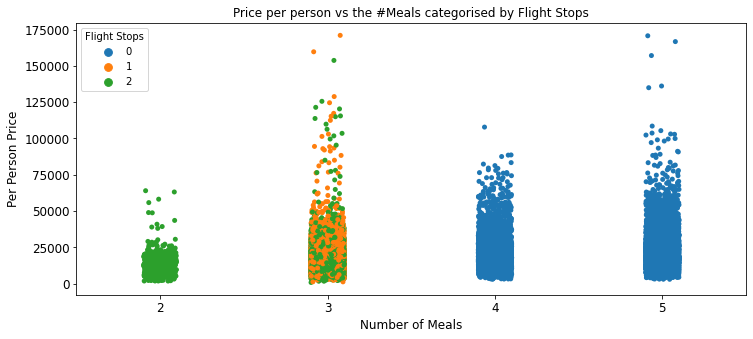

In [1041]:
#price per person vs package type and categorised by start city
sns.stripplot(x='Meals',y='Per Person Price',hue='Flight Stops',data=train)
plt.title('Price per person vs the #Meals categorised by Flight Stops')
plt.xlabel('Number of Meals')
plt.show()

### _Explore the categorical features_

In [1042]:
#list of categorical features
cat_features

['Uniq Id',
 'Package Name',
 'Package Type',
 'Destination',
 'Itinerary',
 'Places Covered',
 'Travel Date',
 'Hotel Details',
 'Start City',
 'Airline',
 'Sightseeing Places Covered',
 'Cancellation Rules']

In [1043]:
#number of cancellation policies / rules
train['Cancellation Rules'].nunique()

10

**_The cancellation rules are as per the travel company policy. The dataset belongs to a single travel company. Cancellation policy do affect the price per person as the travel company would like to offer the flexi policy for a premium. This is also true in case of booking the flight tickets and the travel agent would book a flexi fare tour with the flights depending on the cancellation policy opted by their customers_**

In [1044]:
#check frequency of various cancellation rules
train['Count'] = 1
pd.pivot_table(data=train,index='Cancellation Rules',values='Count',aggfunc='sum')

,Count
Cancellation Rules,
Cancellation any time after making the 1st payment instalment till the 2nd payment date:The entire amount paid as 1st payment instalment (deposit) would be non-refundable.Cancellation after 2nd payment instalment and before 3rd or final payment date:The total amount that was due at the 2nd payment instalment as per your payment schedule would be non-refundable; anything that you have paid over and above this amount would be refundable.Cancellation after 3rd or final payment date:The full amount paid by you would be non-refundable.,17574
"GENERAL Please note that once your booking is confirmed, you will receive an e-mail as well as an SMS on your registered mobile number confirming your booking. However, if you would like to get in touch with us please call us on 0124-4859749. We are open from 8:00 am o?= 8:00 pm, seven days a week Please expect to receive your vouchers 72 hours before your departure date (subject to full payment of your package cost) Please note that these packages are customizable, which means that you will be able to make changes to the itinerary/activity if you so desire. The final payment will be calculated as per the activities reflecting on the website which will be outlined in the confirmatory e-mail sent to youPersonal expenses such as laundry, telephone calls, room service, alcoholic beverages, mini bar etc., are not included In case your package needs to be cancelled due to any natural calamity, weather conditions etc. MakeMyTrip shall strive to give you the maximum possible refund subject to the agreement made with our trade partners/vendorsIf payment is not made as per the schedule provided in the first booking confirmation e-mail, MakeMyTrip reserves the right to cancel the booking after attempting to get in touch with you. Refunds would be as per the package cancellation policyFLIGHTSThe passenger names in the booking form should be exactly as per passports. MakeMyTrip will not bear any liability for the name change fee, if incorrect names and ages have been added at the time of bookingPlease note that if your package includes a flight which is a low cost carrier (Air Asia, Scoot Airlines, Air Arabia, Jetstar, Fly Dubai, Thai AirAsia, Air India Express, Tiger Airways) then baggage will not be included in the package. Baggage can be added as per your requirement at an additional cost depending on the airlines and destination. Our Travel Expert will attempt to get in touch with you within 24-hours after the booking has been confirmed for baggage additionPlease ensure that baggage requirements are given to our Travel Expert latest by 5 days before the date of departureHOTEL Standard check-in time at the hotel is normally 2:00 pm and check-out is 11:00 am. An early check-in, or a late check-out is solely based on the discretion of the hotelIn case the selected hotel is unavailable for booking, an alternate arrangement will be offered to the customer in another hotel of a similar categoryCertain hotels abroad may ask for a security deposit during check-in, which is refundable at check-out subject to the hotelo?=s policy SIGHTSEEING ACTIVITIES/TRANSFERSPlease note that Day at Leisure essentially implies that no sightseeing activities have been included for that day Kindly be on time for your activities, tours and transfers. Most countries are quite strict about following a schedule",1
"GENERAL Please note that once your booking is confirmed, you will receive an e-mail as well as an SMS on your registered mobile number confirming your booking. However, if you would like to get in touch with us please call us on 0124-4859749. We are open from 8:00 am – 8:00 pm, seven days a week Please expect to receive your vouchers 72 hours before your departure date (subject to full payment of your package cost) Please note that these packages are customizable, which means that you will be able to make changes to the itinerary/activity if you so desire. The final payment will be calculated a

In [1045]:
#frequency of each package type
train['Package Type'].value_counts()

Deluxe      6006
Standard    5669
Premium     5581
Luxury      3278
Budget       466
Name: Package Type, dtype: int64

In [1046]:
#check the mean per person price for different package type 
package_price = pd.pivot_table(data=train,values='Per Person Price',index='Package Type',aggfunc='mean')
package_price.sort_values(by='Per Person Price',ascending=False)

,Per Person Price
Package Type,
Premium,23965.407006
Luxury,23679.556437
Deluxe,18409.508825
Standard,16354.089081
Budget,14151.447425


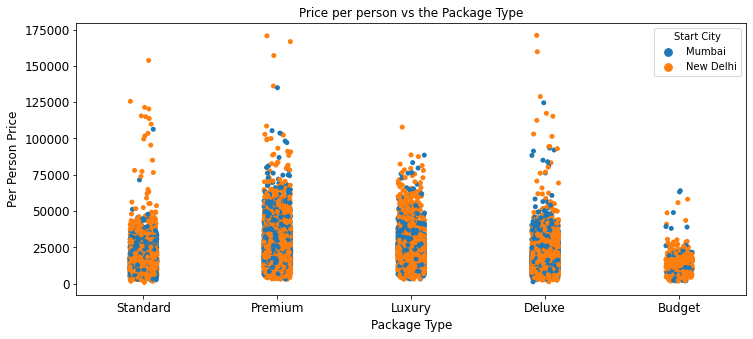

In [1047]:
#price per person vs package type and categorised by start city
sns.stripplot(x='Package Type',y='Per Person Price',hue='Start City',data=train)
plt.title('Price per person vs the Package Type')
plt.show()

<font color = blue> **_The mean priceis highest for Premium and lowest for Budget. However, it is important to note that there is a mix of international and domestic travel package in the dataset. This could be one of the feature to be added to the dataset and could be an important factor to decide the final per price person.The more expensive travel packages are starting from New Delhi_** </font>

In [1048]:
#look at the data again
train.tail(2)

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,Count
20998,51d843fb852ec7abde8299fe31111bd5,Awesome North East with Pelling,Deluxe,Darjeeling|Pelling|Gangtok,2N Darjeeling . 2N Pelling . 2N Gangtok,Darjeeling|Pelling|Gangtok,13-01-2022,Ramada by Wyndham Darjeeling Gandhi Road:4.4|T...,New Delhi,IndiGo,1,3,Tiger Hill | Himalayan Mountaineering Institu...,Cancellation any time after making the 1st pay...,28145.5,1
20999,5ed596587aba74b3f52a59384c04b5a4,"Munnar, Kovalam, Allepey Holiday",Standard,Munnar|Kovalam|Allepey,3N Munnar . 2N Kovalam . 1N Allepey,Munnar|Kovalam|Allepey,30-05-2021,Iceberg Hill Hotel-MMT Holidays Special:3.8|Sa...,New Delhi,IndiGo,2,3,Tata Tea Museum | Eravikulam national park | ...,Cancellation any time after making the 1st pay...,15736.0,1


In [1049]:
#unique number of packages
train['Package Name'].nunique()

2204

In [1050]:
#check the most frequent / booked packages
train['Package Name'].value_counts().sort_values(ascending=False)

Holiday in Manali & Chandigarh from Chandigarh                 37
Bali Special 4 Nights                                          36
Honeymoon Special - Bangkok Phuket & Krabi                     35
Serene Uttarakhand with Kausani                                33
Ultimate Himachal Holiday                                      32
                                                               ..
Nashik - Wine Trail & Tasting                                   1
Heritage of Agra, Gwalior, Orccha, Khajuraho (DEL Special)      1
Weekend Getaway to Sri Lanka with Nuwara Eliya                  1
Luxury Getaway to Udaipur - Stay at the Chunda Palace Hotel     1
A Short Break to Sri Lanka (Without Flights)                    1
Name: Package Name, Length: 2204, dtype: int64

In [1051]:
#check the start city -- > determine whether all travels start from India or elsewhere
train['Start City'].value_counts()

New Delhi    13733
Mumbai        7267
Name: Start City, dtype: int64

<font color=blue> **_All the travel starts from New Delhi and Mumbai_**</font>

In [1052]:
#unique destinations / combination of destinations managed by the travel company
train['Destination'].nunique()

565

In [1053]:
#frequency of the destinations 
train['Destination'].value_counts()

Goa                                      973
Shimla|Manali|Chandigarh                 346
Munnar|Thekkady|Allepey                  328
Port Blair|Havelock|Port Blair           301
Munnar                                   276
                                        ... 
Singapore|Singapore Cruise|Singapore       2
Agra|Gwalior|Orchha|Khajuraho              1
Singapore|Singapore Cruise                 1
Singapore|Melbourne|Gold Coast|Sydney      1
Nuwara Eliya|Bentota|Colombo               1
Name: Destination, Length: 565, dtype: int64

<font color = blue> **_Goa, Shimla, Manali, Munnar are the favorite destinations. The less frequent destunations are the international destinations which can be very expensive depending on the number of places included_**</font>

In [1054]:
#average per person price when destination is Goa alone .. 
train[train['Destination']=='Goa'].groupby('Destination')['Per Person Price'].apply(np.mean)

Destination
Goa    13128.802672
Name: Per Person Price, dtype: float64

In [1055]:
#hotel details
train['Hotel Details'].nunique()

6060

In [1056]:
#top 5 hotel details .. 
train['Hotel Details'].value_counts()[:5]

Not Available                                               2929
Novotel Goa Resort & Spa:4.1                                 115
AMARA GRAND BAGA, GOA- MMT Holidays Special:                 112
Little Mastiff Dharamshala - Unit Of Pong View Hotel:3.9      87
Novotel Goa Resort & Spa:4.2                                  79
Name: Hotel Details, dtype: int64

_Goa is the most favored destination and hence we can see that Goa hotels are where the max stay is booked_

In [1057]:
#check all the hotel details when the destination is in Goa
train[train['Destination']=='Goa']['Hotel Details'].value_counts()

Not Available                                   129
Novotel Goa Resort & Spa:4.1                    115
AMARA GRAND BAGA, GOA- MMT Holidays Special:    112
Novotel Goa Resort & Spa:4.2                     79
The Ocean Park Resort:3.7                        53
                                               ... 
Alila Diwa:4.6                                    1
Bogmallo Beach Resort:3.8                         1
Joia Do Mar Resort:3.8                            1
Cidade De Goa - IHCL SeleQtions:4.5               1
Mykonos Blu:4.4                                   1
Name: Hotel Details, Length: 63, dtype: int64

<font color = blue> **_All the hotel details here show the ratings of the hotel as well. Novotel Goa and Resort is occurring twice due the variation in its overall rating. This could be explained by the fact the booking in this hotel could have been done at two separte cluster of times and the average rating would have changed between these two time clusters._**</font>

In [1058]:
#check a few of the travels where the hotel detail is not available 
train[train['Hotel Details'] ==  'Not Available'][:3]

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,Count
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,1
5,3bb074528941b3a6823371f77b07fb0f,Cochin Trip with Visit to Guruvayoor Temple,Deluxe,Cochin,2N Cochin,Cochin,30-09-2021,Not Available,Mumbai,IndiGo,1,3,Dutch Palace | Jewish Synagogue | St. Francis...,Not Available,8512.0,1
13,3429b7d0a59153d4208e1da2c6375fd6,Holiday in Udaipur & Mount Abu by Volvo from A...,Standard,Udaipur|Mount Abu,2N Udaipur . 1N Mount Abu,Udaipur|Mount Abu,21-05-2021,Not Available,New Delhi,Not Available,2,3,Lake Pichola | Jag Mandir Palace | Return Vol...,Cancellation any time after making the 1st pay...,6911.0,1


In [1059]:
train[train['Hotel Details'] ==  'Not Available'].loc[13]['Package Name']

'Holiday in Udaipur & Mount Abu by Volvo from Ahmedabad'

_There are specific travels which do not require an air ticket as in this case. Volvo is commonly referred as the bus type used for the travel which is generally air conditioned, comfortable and considered premium over the rest._

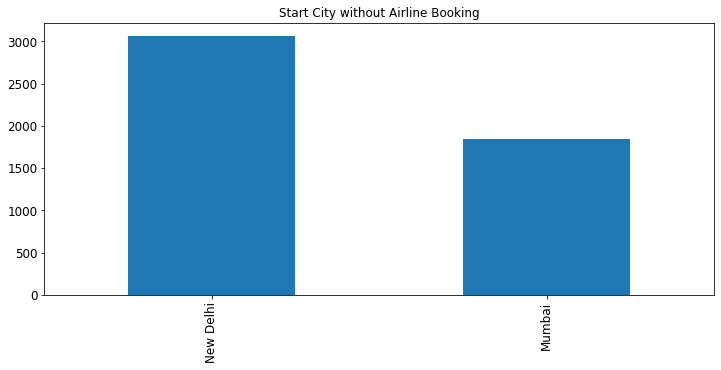

In [1060]:
#start city and no airline booking to the destinations .. 
no_airline = train[train['Airline']=='Not Available']
no_airline['Start City'].value_counts().plot(kind='bar')
plt.title('Start City without Airline Booking')
plt.show()

In [1061]:
train['Itinerary'].value_counts()

3N Goa                                                     453
3N Munnar                                                  223
2N Munnar . 1N Thekkady . 1N Allepey                       219
1N Cochin . 2N Munnar . 1N Thekkady . 1N Allepey           194
1N Mysore . 2N Coorg . 2N Ooty                             193
                                                          ... 
3N Singapore . 2N Singapore Cruise . 2N Singapore            1
1N Nuwara Eliya . 1N Bentota . 1N Colombo                    1
3N Singapore . 3N Melbourne . 2N Gold Coast . 3N Sydney      1
3N Shillong . 2N Kaziranga . 1N Guwahati                     1
2N Leh . 1N Nubra Valley . 1N Leh                            1
Name: Itinerary, Length: 966, dtype: int64

<font color = blue> **_There are 966 unique Itinerary. The destinations are repeating in various and various combination is adding to the uniqueness.By the way 3 Nights in Goa seems to be the favorite_** </font>

In [1062]:
#convert the date column to a datetime object
train['Travel Date'] = pd.to_datetime(train['Travel Date'])
test['Travel Date'] = pd.to_datetime(test['Travel Date'])

In [1063]:
#create a new featute based on travel month 
train['Travel Month'] = train['Travel Date'].dt.month_name()

In [1064]:
test['Travel Month'] = test['Travel Date'].dt.month_name()

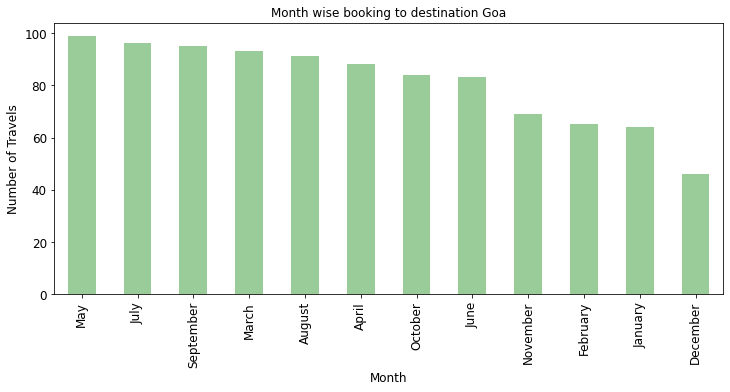

In [1065]:
#preferred month to Goa 
train[train['Destination']=='Goa']['Travel Month'].value_counts().plot(kind='bar',color='green',alpha=0.4)
plt.title('Month wise booking to destination Goa')
plt.xlabel('Month')
plt.ylabel('Number of Travels')
plt.grid(False)
plt.show()

_December is the least as it becomes very expensive during this month in Goa due to new year celebration. Off seasons like May, July and Sep are the top 3 most visited_

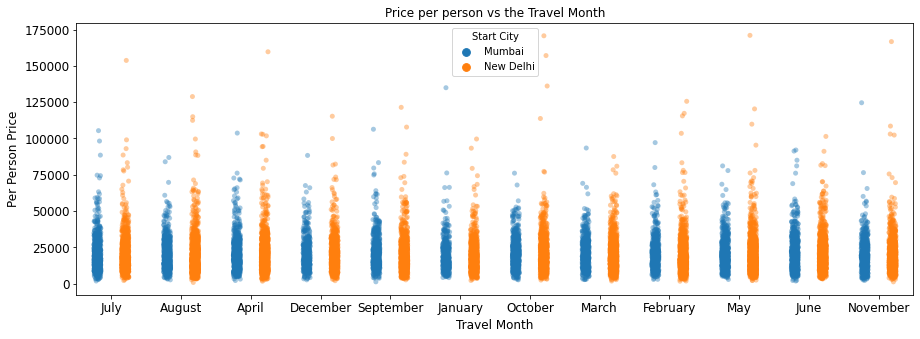

In [1066]:
#price per person vs package type and categorised by start city
plt.figure(figsize=(15,5))
sns.stripplot(x='Travel Month',y='Per Person Price',data=train,alpha=0.4,hue='Start City',dodge=True)
plt.title('Price per person vs the Travel Month')
plt.show()

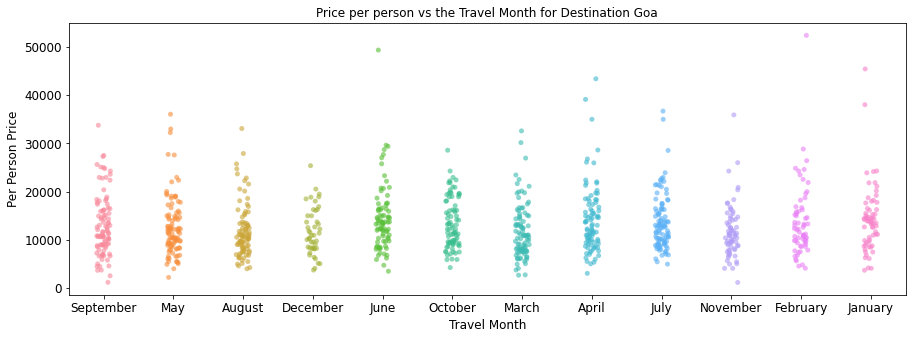

In [1067]:
#price per person vs travel month and destination is goa
plt.figure(figsize=(15,5))
sns.stripplot(x='Travel Month',y='Per Person Price',data=train[train['Destination']=='Goa'],alpha=0.6)
plt.title('Price per person vs the Travel Month for Destination Goa')
plt.show()

In [1068]:
#check whether Destination and Places Covered are identical series
train['Destination'].equals(train['Places Covered'])

True


_The Destination and Place Covered feature have identical information_

In [1069]:
#drop the Places covered from the train and test dataset
train.drop('Places Covered',axis=1,inplace=True)
test.drop('Places Covered',axis=1,inplace=True)

## _Feature Extraction_

In [1070]:
train.head(1)

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,Count,Travel Month
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,2021-07-30,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,1,July


In [1071]:
#create a new featute based on travel weekday
train['Travel Start Day'] = train['Travel Date'].dt.weekday
test['Travel Start Day'] = test['Travel Date'].dt.weekday

In [1072]:
#for modeling the integer representation of the month will be more appropriate .. 
train['Travel Month'] = train['Travel Date'].dt.month
test['Travel Month'] = test['Travel Date'].dt.month

In [1073]:
#create a new featute based on travel year
train['Travel Year'] = train['Travel Date'].dt.year
test['Travel Year'] = test['Travel Date'].dt.year

In [1074]:
#conver to float -- better for neural network models
train['Travel Start Day'] = train['Travel Start Day'].astype('float')
test['Travel Start Day'] = test['Travel Start Day'].astype('float')

train['Travel Month'] = train['Travel Month'].astype('float')
test['Travel Month'] = test['Travel Month'].astype('float')

train['Meals'] = train['Meals'].astype('float')
test['Meals'] = test['Meals'].astype('float')

train['Flight Stops'] = train['Flight Stops'].astype('float')
test['Flight Stops'] = test['Flight Stops'].astype('float')

In [1075]:
#one hot encoding for the Start City feature
start_city = pd.get_dummies(train['Start City'],drop_first=True)
train = pd.concat([train,start_city],axis=1)
train.drop('Start City',axis=1,inplace=True)
train.head(1)

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Travel Date,Hotel Details,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,Count,Travel Month,Travel Start Day,Travel Year,New Delhi
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,2021-07-30,Not Available,Not Available,2.0,3.0,Not Available,Not Available,11509.0,1,7.0,4.0,2021,0


In [1076]:
#one hot encoding for the Start City feature in test dataset
start_city = pd.get_dummies(test['Start City'],drop_first=True)
test = pd.concat([test,start_city],axis=1)
test.drop('Start City',axis=1,inplace=True)
test.head(1)

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Travel Date,Hotel Details,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Travel Month,Travel Start Day,Travel Year,New Delhi
0,12c47aefbcca65d6156ba0bc7946704b,Goa 5N stay with flights & Transfers-North Goa,Luxury,Goa,5N Goa,2021-07-13,Novotel Goa Resort & Spa:4.1,IndiGo,0.0,4.0,Not Available,Cancellation any time after making the 1st pay...,7.0,1.0,2021,1


In [1077]:
#one hot encoding for the package type in the train dataset
package_type = pd.get_dummies(train['Package Type'],drop_first=True)
train = pd.concat([train,package_type],axis=1)
train.drop('Package Type',axis=1,inplace=True)

#one hot encoding of the package type in the test dataset
package_type = pd.get_dummies(test['Package Type'],drop_first=True)
test = pd.concat([test,package_type],axis=1)
test.drop('Package Type',axis=1,inplace=True)

In [1078]:
#drop the uniq id from the feature set
train.drop('Uniq Id',axis=1,inplace=True)
test.drop('Uniq Id',axis=1,inplace=True)

In [1079]:
#drop the dummy count column created earlier
train.drop('Count',axis=1,inplace=True)

In [1080]:
#view the new dataframe 
train.head(2)

,Package Name,Destination,Itinerary,Travel Date,Hotel Details,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,Travel Month,Travel Start Day,Travel Year,New Delhi,Deluxe,Luxury,Premium,Standard
0,Best of Shimla and Manali Holiday from Delhi,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,2021-07-30,Not Available,Not Available,2.0,3.0,Not Available,Not Available,11509.0,7.0,4.0,2021,0,0,0,0,1
1,Kashmir Valley vacation,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,2021-08-12,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,IndiGo|IndiGo,0.0,5.0,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,8.0,3.0,2021,1,0,0,1,0


In [1081]:
#convert travel year to object and one hot encode , there are only two years 2021 and 2022
train['Travel Year'] = train['Travel Year'].astype(str)
test['Travel Year'] = test['Travel Year'].astype(str)

travel_year = pd.get_dummies(train['Travel Year'],drop_first=True)
train = pd.concat([train,travel_year],axis=1)
train.drop('Travel Year',axis=1,inplace=True)

travel_year = pd.get_dummies(test['Travel Year'],drop_first=True)
test = pd.concat([test,travel_year],axis=1)
test.drop('Travel Year',axis=1,inplace=True)

### _Feature extraction_
#### _Destination feature_
***
_The places in the Destination feature can be converted to separate columns and then lable encoded_

In [1082]:
# new data frame with split value columns on the destination feature
new = train['Destination'].str.split('|',expand = True) 
new.head(3)

,0,1,2,3,4,5,6,7,8,9,10
0,New Delhi,Shimla,Manali,Chandigarh,None,None,None,None,None,None,None
1,Srinagar,Pahalgam,Srinagar,None,None,None,None,None,None,None,None
2,Udaipur,Chittorgarh,None,None,None,None,None,None,None,None,None


In [1083]:
#check the info 
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       21000 non-null  object
 1   1       15637 non-null  object
 2   2       10305 non-null  object
 3   3       4740 non-null   object
 4   4       1377 non-null   object
 5   5       328 non-null    object
 6   6       151 non-null    object
 7   7       49 non-null     object
 8   8       37 non-null     object
 9   9       6 non-null      object
 10  10      6 non-null      object
dtypes: object(11)
memory usage: 1.8+ MB


<font color=blue> _The first 3 columns contains the maximum information of the key places a person would visit. The number of rows where the number of places is 10 is only 6. May be retaining upto the 4th place column would be more justified_</font>

In [1084]:
new.columns = ['place_1','place_2','place_3','place_4','place_5','place_6','place_7','place_8',
              'place_9','place_10','place_11']
new.head(2)

,place_1,place_2,place_3,place_4,place_5,place_6,place_7,place_8,place_9,place_10,place_11
0,New Delhi,Shimla,Manali,Chandigarh,None,None,None,None,None,None,None
1,Srinagar,Pahalgam,Srinagar,None,None,None,None,None,None,None,None


In [1085]:
new.drop(['place_5','place_6','place_7','place_8','place_9','place_10','place_11'],axis=1,
        inplace=True)
new.head(2)


,place_1,place_2,place_3,place_4
0,New Delhi,Shimla,Manali,Chandigarh
1,Srinagar,Pahalgam,Srinagar,None


In [1086]:
#append to the train column .. 
train = pd.concat([train,new],axis=1)

In [1087]:
new = test['Destination'].str.split('|',expand = True) 
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       9000 non-null   object
 1   1       6696 non-null   object
 2   2       4394 non-null   object
 3   3       1986 non-null   object
 4   4       604 non-null    object
 5   5       130 non-null    object
 6   6       66 non-null     object
 7   7       16 non-null     object
 8   8       14 non-null     object
 9   9       3 non-null      object
 10  10      3 non-null      object
dtypes: object(11)
memory usage: 773.6+ KB


In [1088]:
#repeat the steps on the test dataset 
new = test['Destination'].str.split('|',expand = True) 
new.columns = ['place_1','place_2','place_3','place_4','place_5','place_6','place_7','place_8',
              'place_9','place_10','place_11']
new.drop(['place_5','place_6','place_7','place_8','place_9','place_10','place_11'],axis=1,
        inplace=True)
#append to the test column .. 
test = pd.concat([test,new],axis=1)

In [1089]:
#add a new feature = number of places covered durign the trip 
'''The function definition is below. This feature was added later.'''
#create the new feature -- > number of hotels booked during the trip
train['num_destination'] = num_sightseeing(dataset=train,col='Destination')
test['num_destination'] =  num_sightseeing(dataset=test,col='Destination')

In [1090]:
#drop the redundant Destination column from the train and test dataset
train.drop('Destination',axis=1,inplace=True)
test.drop('Destination',axis=1,inplace=True)

In [1091]:
#replace the None in place_* with Not Available string
places = ['place_1','place_2','place_3','place_4']
for col in places:
    train[col].replace([None],np.nan,inplace=True)
    test[col].replace([None],np.nan,inplace=True)
    train[col].fillna('Not Available',inplace=True)
    test[col].fillna('Not Available',inplace=True)

In [1092]:
train.head(3)

,Package Name,Itinerary,Travel Date,Hotel Details,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,Travel Month,Travel Start Day,New Delhi,Deluxe,Luxury,Premium,Standard,2022,place_1,place_2,place_3,place_4,num_destination
0,Best of Shimla and Manali Holiday from Delhi,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,2021-07-30,Not Available,Not Available,2.0,3.0,Not Available,Not Available,11509.0,7.0,4.0,0,0,0,0,1,0,New Delhi,Shimla,Manali,Chandigarh,3
1,Kashmir Valley vacation,1N Srinagar . 2N Pahalgam . 1N Srinagar,2021-08-12,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,IndiGo|IndiGo,0.0,5.0,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,8.0,3.0,1,0,0,1,0,0,Srinagar,Pahalgam,Srinagar,Not Available,2
2,Might of Mewar- Udaipur and Chittorgarh,2N Udaipur . 1N Chittorgarh,2021-04-26,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,IndiGo,0.0,4.0,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5,4.0,0.0,1,0,1,0,0,0,Udaipur,Chittorgarh,Not Available,Not Available,1


In [1093]:
test.head(2)

,Package Name,Itinerary,Travel Date,Hotel Details,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Travel Month,Travel Start Day,New Delhi,Deluxe,Luxury,Premium,Standard,2022,place_1,place_2,place_3,place_4,num_destination
0,Goa 5N stay with flights & Transfers-North Goa,5N Goa,2021-07-13,Novotel Goa Resort & Spa:4.1,IndiGo,0.0,4.0,Not Available,Cancellation any time after making the 1st pay...,7.0,1.0,1,0,1,0,0,0,Goa,Not Available,Not Available,Not Available,0
1,Into the Wild - Weekend at Bandipur National Park,2N Bandipur,2021-03-20,The Windflower Jungle Resorts & Spa Bandipur:4.4,Not Available,0.0,4.0,Bandipur National Park,This cancellation policy is applicable for boo...,3.0,5.0,1,0,1,0,0,0,Bandipur,Not Available,Not Available,Not Available,0


#### _Airline Feature_

In [1094]:
#create separate columns for the various airlines in the train dataset 
airline = train['Airline'].str.split('|',expand = True) 
airline.columns = ['airline_1','airline_2','airline_3','airline_4','airline_5','airline_6','airline_7','airline_8',
                   'airline_9','airline_10','airline_11']
airline.drop(['airline_5','airline_6','airline_7','airline_8','airline_9','airline_10','airline_11'],
             axis=1,inplace=True)

#append to the train column .. 
train = pd.concat([train,airline],axis=1)

#create separate columns for the various airlines in the test dataset 
airline = test['Airline'].str.split('|',expand = True) 
airline.columns = ['airline_1','airline_2','airline_3','airline_4','airline_5','airline_6','airline_7']
airline.drop(['airline_5','airline_6','airline_7'],
             axis=1,inplace=True)

#append to the test column .. 
test = pd.concat([test,airline],axis=1)

#new feature = number of airlines booked
#create the new feature -- > number of hotels booked during the trip
train['num_airlines'] = num_sightseeing(dataset=train,col='Airline')
test['num_airlines'] =  num_sightseeing(dataset=test,col='Airline')


#drop the redundant airline column
train.drop('Airline',axis=1,inplace=True)
test.drop('Airline',axis=1,inplace=True)

#replace the None in place_* with Not Available string
airlines = ['airline_1','airline_2','airline_3','airline_4']
for col in airlines:
    train[col].replace([None],np.nan,inplace=True)
    test[col].replace([None],np.nan,inplace=True)
    train[col].fillna('Not Available',inplace=True)
    test[col].fillna('Not Available',inplace=True)


In [1095]:
#drop the Travel Date column from both the train and test dataset 
train.drop('Travel Date',axis=1,inplace=True)
test.drop('Travel Date',axis=1,inplace=True)

In [1096]:
train.head()

,Package Name,Itinerary,Hotel Details,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,Travel Month,Travel Start Day,New Delhi,Deluxe,Luxury,Premium,Standard,2022,place_1,place_2,place_3,place_4,num_destination,airline_1,airline_2,airline_3,airline_4,num_airlines
0,Best of Shimla and Manali Holiday from Delhi,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,Not Available,2.0,3.0,Not Available,Not Available,11509.0,7.0,4.0,0,0,0,0,1,0,New Delhi,Shimla,Manali,Chandigarh,3,Not Available,Not Available,Not Available,Not Available,-1
1,Kashmir Valley vacation,1N Srinagar . 2N Pahalgam . 1N Srinagar,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,0.0,5.0,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,8.0,3.0,1,0,0,1,0,0,Srinagar,Pahalgam,Srinagar,Not Available,2,IndiGo,IndiGo,Not Available,Not Available,1
2,Might of Mewar- Udaipur and Chittorgarh,2N Udaipur . 1N Chittorgarh,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,0.0,4.0,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5,4.0,0.0,1,0,1,0,0,0,Udaipur,Chittorgarh,Not Available,Not Available,1,IndiGo,Not Available,Not Available,Not Available,0
3,Colorful Kerala ( Romantic Getaway ),2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Elixir Hills Suites Resort & Spa-MMT Holidays ...,0.0,5.0,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0,8.0,4.0,1,0,0,1,0,0,Munnar,Kumarakom,Allepey,Kovalam and Poovar,3,IndiGo,Not Available,Not Available,Not Available,0
4,A Week In Bangkok & Pattaya,4N Pattaya . 3N Bangkok,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,0.0,5.0,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0,12.0,6.0,1,0,0,1,0,0,Pattaya,Bangkok,Not Available,Not Available,1,Spicejet,Go Air,Not Available,Not Available,1


#### _Sight Seeing Places_

In [1097]:
#create the new feature -- > number of sight seeing places
train['num_sightseeing'] = num_sightseeing(train)
test['num_sightseeing'] =  num_sightseeing(test)

In [1098]:
train.head(2)

,Package Name,Itinerary,Hotel Details,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,Travel Month,Travel Start Day,New Delhi,Deluxe,Luxury,Premium,Standard,2022,place_1,place_2,place_3,place_4,num_destination,airline_1,airline_2,airline_3,airline_4,num_airlines,num_sightseeing
0,Best of Shimla and Manali Holiday from Delhi,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,Not Available,2.0,3.0,Not Available,Not Available,11509.0,7.0,4.0,0,0,0,0,1,0,New Delhi,Shimla,Manali,Chandigarh,3,Not Available,Not Available,Not Available,Not Available,-1,-1
1,Kashmir Valley vacation,1N Srinagar . 2N Pahalgam . 1N Srinagar,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,0.0,5.0,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,8.0,3.0,1,0,0,1,0,0,Srinagar,Pahalgam,Srinagar,Not Available,2,IndiGo,IndiGo,Not Available,Not Available,1,6


In [1099]:
#drop the original Sightseeing column from both the train and test dataset 
train.drop('Sightseeing Places Covered',axis=1,inplace=True)
test.drop('Sightseeing Places Covered',axis=1,inplace=True)

In [1100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Package Name        21000 non-null  object 
 1   Itinerary           21000 non-null  object 
 2   Hotel Details       21000 non-null  object 
 3   Flight Stops        21000 non-null  float64
 4   Meals               21000 non-null  float64
 5   Cancellation Rules  21000 non-null  object 
 6   Per Person Price    21000 non-null  float64
 7   Travel Month        21000 non-null  float64
 8   Travel Start Day    21000 non-null  float64
 9   New Delhi           21000 non-null  uint8  
 10  Deluxe              21000 non-null  uint8  
 11  Luxury              21000 non-null  uint8  
 12  Premium             21000 non-null  uint8  
 13  Standard            21000 non-null  uint8  
 14  2022                21000 non-null  uint8  
 15  place_1             21000 non-null  object 
 16  plac

In [1101]:
#check the new dataframe
train.head(2)

,Package Name,Itinerary,Hotel Details,Flight Stops,Meals,Cancellation Rules,Per Person Price,Travel Month,Travel Start Day,New Delhi,Deluxe,Luxury,Premium,Standard,2022,place_1,place_2,place_3,place_4,num_destination,airline_1,airline_2,airline_3,airline_4,num_airlines,num_sightseeing
0,Best of Shimla and Manali Holiday from Delhi,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,Not Available,2.0,3.0,Not Available,11509.0,7.0,4.0,0,0,0,0,1,0,New Delhi,Shimla,Manali,Chandigarh,3,Not Available,Not Available,Not Available,Not Available,-1,-1
1,Kashmir Valley vacation,1N Srinagar . 2N Pahalgam . 1N Srinagar,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,0.0,5.0,Cancellation any time after making the 1st pay...,22485.5,8.0,3.0,1,0,0,1,0,0,Srinagar,Pahalgam,Srinagar,Not Available,2,IndiGo,IndiGo,Not Available,Not Available,1,6


In [1102]:
#lets drop the cancellation rules in the first iteration of the modeling
train.drop('Cancellation Rules',axis=1,inplace=True)
test.drop('Cancellation Rules',axis=1,inplace=True)

_Package Name information is well reflected in the destination feature. Hence this could be a redundant or very similar feature. For simplicity lets drop this column as well_

In [1103]:
#drop the package name
train.drop('Package Name',axis=1,inplace=True)
test.drop('Package Name',axis=1,inplace=True)

<b> _Now we have two very important features from which features can be extracted. From the itinerary, the number of nights will be an important feature that can be derived. From the hotel details, the number of hotels and average rating of the hotels would also be an important feature. Good rating of hotels yields higher booking numbers and amount_ </b>

#### _Itinerary_

In [1104]:
#create a column with list of all the night stay at different hotels .. 
import re

train['num_nights'] = ''
for i in range(len(train)):
    temp = sum(list(map(int,re.findall(r'\d+',train['Itinerary'][i]))))
    train['num_nights'][i] = temp

In [1105]:
test['num_nights'] = ''
for j in range(len(test)):
    temp_test = sum(list(map(int,re.findall(r'\d+',test['Itinerary'][j]))))
    test['num_nights'][j] = temp_test

In [1106]:
#drop the itinerary column from the train and test set
train.drop('Itinerary',axis=1,inplace=True)
test.drop('Itinerary',axis=1,inplace=True)

#### _Hotel Details_
- Number of Hotels Booked
- Average Rating of the Hotels selected


In [1107]:
train.head(2)

,Hotel Details,Flight Stops,Meals,Per Person Price,Travel Month,Travel Start Day,New Delhi,Deluxe,Luxury,Premium,Standard,2022,place_1,place_2,place_3,place_4,num_destination,airline_1,airline_2,airline_3,airline_4,num_airlines,num_sightseeing,num_nights
0,Not Available,2.0,3.0,11509.0,7.0,4.0,0,0,0,0,1,0,New Delhi,Shimla,Manali,Chandigarh,3,Not Available,Not Available,Not Available,Not Available,-1,-1,6
1,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,0.0,5.0,22485.5,8.0,3.0,1,0,0,1,0,0,Srinagar,Pahalgam,Srinagar,Not Available,2,IndiGo,IndiGo,Not Available,Not Available,1,6,4


In [1108]:
#create the new feature -- > number of hotels booked during the trip
train['num_hotels'] = num_sightseeing(dataset=train,col='Hotel Details')
test['num_hotels'] =  num_sightseeing(dataset=test,col='Hotel Details')

In [1109]:
train.head(1)

,Hotel Details,Flight Stops,Meals,Per Person Price,Travel Month,Travel Start Day,New Delhi,Deluxe,Luxury,Premium,Standard,2022,place_1,place_2,place_3,place_4,num_destination,airline_1,airline_2,airline_3,airline_4,num_airlines,num_sightseeing,num_nights,num_hotels
0,Not Available,2.0,3.0,11509.0,7.0,4.0,0,0,0,0,1,0,New Delhi,Shimla,Manali,Chandigarh,3,Not Available,Not Available,Not Available,Not Available,-1,-1,6,-1


In [1110]:
train['avg_rating'] = ''
for i in range(len(train)):
    temp = np.mean(list(map(int,re.findall(r'\d+',train['Hotel Details'][i]))))
    train['avg_rating'][i] = temp
    
test['avg_rating'] = ''
for i in range(len(test)):
    temp = np.mean(list(map(int,re.findall(r'\d+',test['Hotel Details'][i]))))
    test['avg_rating'][i] = temp

In [1111]:
train['avg_rating'].median()

4.0

In [1112]:
train.head(2)

,Hotel Details,Flight Stops,Meals,Per Person Price,Travel Month,Travel Start Day,New Delhi,Deluxe,Luxury,Premium,Standard,2022,place_1,place_2,place_3,place_4,num_destination,airline_1,airline_2,airline_3,airline_4,num_airlines,num_sightseeing,num_nights,num_hotels,avg_rating
0,Not Available,2.0,3.0,11509.0,7.0,4.0,0,0,0,0,1,0,New Delhi,Shimla,Manali,Chandigarh,3,Not Available,Not Available,Not Available,Not Available,-1,-1,6,-1,NaN
1,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,0.0,5.0,22485.5,8.0,3.0,1,0,0,1,0,0,Srinagar,Pahalgam,Srinagar,Not Available,2,IndiGo,IndiGo,Not Available,Not Available,1,6,4,2,4.16667


In [1113]:
test.head(2)

,Hotel Details,Flight Stops,Meals,Travel Month,Travel Start Day,New Delhi,Deluxe,Luxury,Premium,Standard,2022,place_1,place_2,place_3,place_4,num_destination,airline_1,airline_2,airline_3,airline_4,num_airlines,num_sightseeing,num_nights,num_hotels,avg_rating
0,Novotel Goa Resort & Spa:4.1,0.0,4.0,7.0,1.0,1,0,1,0,0,0,Goa,Not Available,Not Available,Not Available,0,IndiGo,Not Available,Not Available,Not Available,0,-1,5,0,2.5
1,The Windflower Jungle Resorts & Spa Bandipur:4.4,0.0,4.0,3.0,5.0,1,0,1,0,0,0,Bandipur,Not Available,Not Available,Not Available,0,Not Available,Not Available,Not Available,Not Available,-1,0,2,0,4


In [1114]:
#fill the NaN values in avg_rating to 0 
train['avg_rating'].fillna(0,inplace=True)
test['avg_rating'].fillna(0,inplace=True)

In [1115]:
#drop the Hotel Details
train.drop('Hotel Details',axis=1,inplace=True)
test.drop('Hotel Details',axis=1,inplace=True)

In [1116]:
train.head(2)

,Flight Stops,Meals,Per Person Price,Travel Month,Travel Start Day,New Delhi,Deluxe,Luxury,Premium,Standard,2022,place_1,place_2,place_3,place_4,num_destination,airline_1,airline_2,airline_3,airline_4,num_airlines,num_sightseeing,num_nights,num_hotels,avg_rating
0,2.0,3.0,11509.0,7.0,4.0,0,0,0,0,1,0,New Delhi,Shimla,Manali,Chandigarh,3,Not Available,Not Available,Not Available,Not Available,-1,-1,6,-1,0.000000
1,0.0,5.0,22485.5,8.0,3.0,1,0,0,1,0,0,Srinagar,Pahalgam,Srinagar,Not Available,2,IndiGo,IndiGo,Not Available,Not Available,1,6,4,2,4.166667


In [1117]:
encode_features=['place_1','place_2','place_3','place_4','airline_1','airline_2','airline_3','airline_4']
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for col in encode_features:
    encoder.fit(list(train[col].values) + list(test[col].values))
    train[col] = encoder.transform(list(train[col].values))
    test[col] = encoder.transform(list(test[col].values))

In [1118]:
train.head()

,Flight Stops,Meals,Per Person Price,Travel Month,Travel Start Day,New Delhi,Deluxe,Luxury,Premium,Standard,2022,place_1,place_2,place_3,place_4,num_destination,airline_1,airline_2,airline_3,airline_4,num_airlines,num_sightseeing,num_nights,num_hotels,avg_rating
0,2.0,3.0,11509.0,7.0,4.0,0,0,0,0,1,0,79,118,54,9,3,21,27,32,26,-1,-1,6,-1,0.000000
1,0.0,5.0,22485.5,8.0,3.0,1,0,0,1,0,0,107,95,90,46,2,16,20,32,26,1,6,4,2,4.166667
2,0.0,4.0,12421.5,4.0,0.0,1,0,1,0,0,0,113,24,66,46,1,16,27,32,26,0,7,3,1,4.000000
3,0.0,5.0,35967.0,8.0,4.0,1,0,0,1,0,0,71,68,0,33,3,16,27,32,26,0,8,6,3,4.500000
4,0.0,5.0,25584.0,12.0,6.0,1,0,0,1,0,0,86,13,66,46,1,26,18,32,26,1,1,7,1,3.750000


In [1119]:
test.head()

,Flight Stops,Meals,Travel Month,Travel Start Day,New Delhi,Deluxe,Luxury,Premium,Standard,2022,place_1,place_2,place_3,place_4,num_destination,airline_1,airline_2,airline_3,airline_4,num_airlines,num_sightseeing,num_nights,num_hotels,avg_rating
0,0.0,4.0,7.0,1.0,1,0,1,0,0,0,35,90,66,46,0,16,27,32,26,0,-1,5,0,2.50
1,0.0,4.0,3.0,5.0,1,0,1,0,0,0,10,90,66,46,0,21,27,32,26,-1,0,2,0,4.00
2,2.0,3.0,9.0,4.0,1,0,0,0,1,1,71,90,66,46,0,21,27,32,26,-1,3,3,-1,0.00
3,1.0,3.0,5.0,6.0,0,1,0,0,0,0,71,90,66,46,0,21,27,32,26,-1,5,3,-1,0.00
4,0.0,4.0,10.0,2.0,1,0,1,0,0,0,21,83,92,1,3,16,27,32,26,0,9,5,3,4.75


In [1120]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Flight Stops      21000 non-null  float64
 1   Meals             21000 non-null  float64
 2   Per Person Price  21000 non-null  float64
 3   Travel Month      21000 non-null  float64
 4   Travel Start Day  21000 non-null  float64
 5   New Delhi         21000 non-null  uint8  
 6   Deluxe            21000 non-null  uint8  
 7   Luxury            21000 non-null  uint8  
 8   Premium           21000 non-null  uint8  
 9   Standard          21000 non-null  uint8  
 10  2022              21000 non-null  uint8  
 11  place_1           21000 non-null  int64  
 12  place_2           21000 non-null  int64  
 13  place_3           21000 non-null  int64  
 14  place_4           21000 non-null  int64  
 15  num_destination   21000 non-null  int64  
 16  airline_1         21000 non-null  int64 

In [1121]:
#conver the num_nights to numerical
train['num_nights'] = train['num_nights'].astype(int)
train['num_nights'] = train['num_nights'].astype(int)

In [1122]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Flight Stops      21000 non-null  float64
 1   Meals             21000 non-null  float64
 2   Per Person Price  21000 non-null  float64
 3   Travel Month      21000 non-null  float64
 4   Travel Start Day  21000 non-null  float64
 5   New Delhi         21000 non-null  uint8  
 6   Deluxe            21000 non-null  uint8  
 7   Luxury            21000 non-null  uint8  
 8   Premium           21000 non-null  uint8  
 9   Standard          21000 non-null  uint8  
 10  2022              21000 non-null  uint8  
 11  place_1           21000 non-null  int64  
 12  place_2           21000 non-null  int64  
 13  place_3           21000 non-null  int64  
 14  place_4           21000 non-null  int64  
 15  num_destination   21000 non-null  int64  
 16  airline_1         21000 non-null  int64 

In [1123]:
#check the correlation with the numerical features 
train.corr()['Per Person Price'].sort_values(ascending=False)

Per Person Price    1.000000
num_nights          0.510186
num_airlines        0.476219
num_hotels          0.338355
num_destination     0.317759
Meals               0.266456
Premium             0.201832
num_sightseeing     0.138249
Luxury              0.133723
avg_rating          0.014413
Travel Month        0.011263
2022                0.006344
place_1             0.002526
Travel Start Day    0.001018
New Delhi          -0.047014
airline_1          -0.069849
place_4            -0.074554
Deluxe             -0.089679
place_2            -0.105698
place_3            -0.116108
airline_2          -0.127638
airline_4          -0.142923
airline_3          -0.155456
Standard           -0.193511
Flight Stops       -0.281276
Name: Per Person Price, dtype: float64

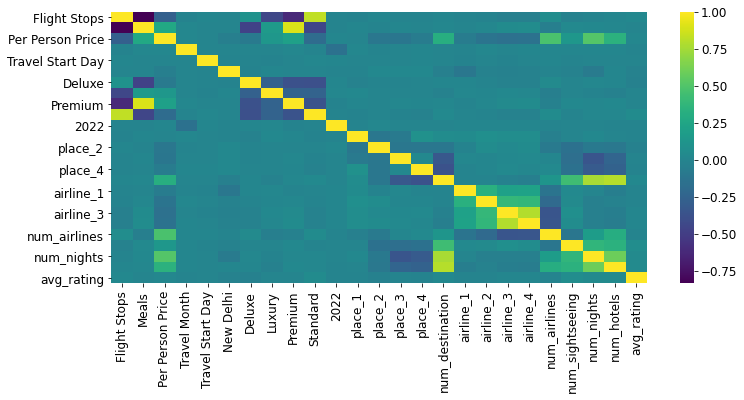

In [1124]:
#construct the heatmap
sns.heatmap(train.corr(),cmap='viridis')
plt.show()

## _Transformation, Dimensionality Reduction and Modeling_

In [1125]:
#split the dataset into train and test set
seed = 21
X = train.drop('Per Person Price',axis=1)
y = train['Per Person Price']

X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.1,random_state=seed)
X_train.shape, X_test.shape

((18900, 24), (2100, 24))

In [1126]:
from sklearn.model_selection import GridSearchCV
rf_reg = RandomForestRegressor(random_state=seed)
params = {'n_estimators':[100,300,500],'max_depth':[14,21,25]}
grid = GridSearchCV(estimator=rf_reg,param_grid=params,cv=10,scoring='neg_mean_squared_log_error')
grid_fit = grid.fit(X_train,y_train)

In [1127]:
grid_fit.best_estimator_

RandomForestRegressor(max_depth=25, n_estimators=500, random_state=21)

In [1128]:
grid_fit.best_score_

-0.0418922645638785

In [1129]:
rf_reg = grid_fit.best_estimator_
rf_reg.fit(X_train,y_train)
rf_reg_train_pred = rf_reg.predict(X_test)
msle = mean_squared_log_error(y_test,rf_reg_train_pred)
print('RMSLE: %.3f'%(np.sqrt(msle)))

RMSLE: 0.202


In [1130]:
#fit the model on the entire training dataset before the final predictions
rf_reg.fit(X,y)
final_pred = rf_reg.predict(test)

In [1131]:
#create a submission df based on the submission format .. 
submission = pd.DataFrame(data=final_pred,columns=['Per Person Price'])

In [1132]:
#create the submission file -- >  yields 0.19474 (top30% on the Public Leaderboard)
submission.to_csv('rf_submission.csv')

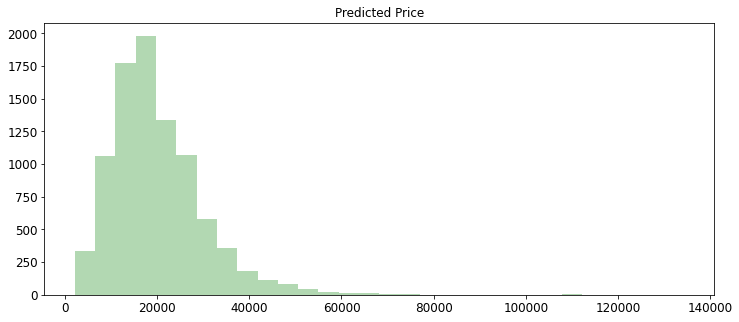

In [1133]:
plt.hist(submission['Per Person Price'],bins=30,color='green',alpha=0.3)
plt.title('Predicted Price')
plt.show()

## _Deep Neural Network_

In [1134]:
#scale the data before feeding to the dense neural network 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [1135]:
#Deep Neural Network for Per Person Price Prediction
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [1136]:
#define the early stopping callback
callback = EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=True)

#define the model
model = Sequential()
#add the layers 
model.add(Dense(500,input_dim=X_train.shape[1],activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(300,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(150,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(75,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(25,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
#compile the model
model.compile(optimizer='adam',loss='mean_squared_logarithmic_error',metrics=['mse'])
#print summary
model.summary()
#fit the model
history = model.fit(X_train,y_train,epochs=500,callbacks=[callback],verbose=0,batch_size=32,validation_data=(X_test,y_test))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 500)               12500     
_________________________________________________________________
dropout_38 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_39 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 150)               45150     
_________________________________________________________________
dropout_40 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 75)               

In [1137]:
loss = pd.DataFrame(history.history)
loss.head(3)

,loss,mse,val_loss,val_mse
0,4.027169,204401184.0,0.141915,83500736.0
1,0.177787,98879056.0,0.111942,70692392.0
2,0.159347,90287000.0,0.102214,65591768.0


In [1138]:
#prediction on the tet data .. 
test =  scaler.transform(test)
predictions = model.predict(test)

In [1139]:
nn_pred = pd.DataFrame(predictions,columns=['Per Person Price'])
nn_pred.to_csv('nn_submission.csv')

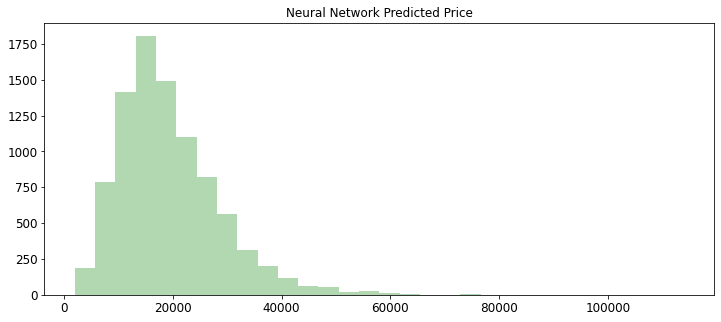

In [1140]:
plt.hist(nn_pred['Per Person Price'],bins=30,color='green',alpha=0.3)
plt.title('Neural Network Predicted Price')
plt.show()

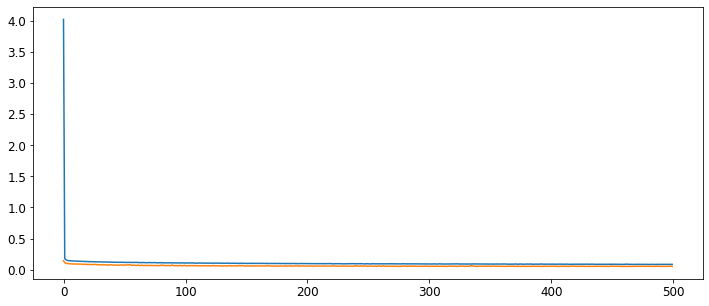

In [1144]:
plt.plot(loss[['loss','val_loss']])
plt.show()